In [2]:
# must install comet ml before any other ml libraries
%pip install comet-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.7/586.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 46.5 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.6.4
    Uninstalling websocket-client-1.6.4:
      Successfully uninstalled websocket-client-1.6.4
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [3]:
# initialize comet by adding project name and api key
import comet_ml
comet_ml.init(project_name='huggingface')

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [4]:
%pip install torch numpy scikit-learn transformers datasets transformers[torch] huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 31.6 MB/s eta 0:00:00


In [5]:
from transformers import TrainingArguments, AutoTokenizer, \
                         AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import torch
from torch import nn

# defines and returns parameters used throughout
def get_parameters():

    columns_to_remove = [
        'author',
        'subreddit',
        'link_id',
        'parent_id',
        'created_utc',
        'rater_id',
        'example_very_unclear',
        'admiration',
        'approval',
        'caring',
        'confusion',
        'desire',
        'disappointment',
        'disapproval',
        'excitement',
        'nervousness',
        'pride',
        'realization',
        'relief',
        'remorse',
        'surprise'
    ]

    emotions = [
        'amusement',
        'anger',
        'annoyance',
        'curiosity',
        'disgust',
        'embarrassment',
        'fear',
        'gratitude',
        'grief',
        'joy',
        'love',
        'optimism',
        'sadness',
        'neutral'
    ]

    training_args = TrainingArguments(
        output_dir='./model_output',
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        save_total_limit=3,
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
         greater_is_better=True,
        report_to='comet_ml'
   )

    id2label = {idx:label for idx, label in enumerate(emotions)}
    label2id = {label:idx for idx, label in enumerate(emotions)}

    tokenizer = AutoTokenizer.from_pretrained("roberta-base")

    roberta_base_model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=len(emotions),
        problem_type="multi_label_classification",
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    model = RobertaLSTM(roberta_base_model, lstm_hidden_size=128, num_labels=len(emotions))


    settings = {
        'columns_to_remove': columns_to_remove,
        'emotions': emotions,
        'training_args': training_args,
        'num_labels': len(emotions),
        'tokenizer': tokenizer,
        'model': model
    }

    return settings

class RobertaLSTM(nn.Module):
    def __init__(self, roberta_model, lstm_hidden_size, num_labels):
        super(RobertaLSTM, self).__init__()
        self.num_labels = num_labels
        self.roberta = roberta_model.roberta

        self.pre_classifier = nn.Linear(768, lstm_hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(input_size=lstm_hidden_size, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.attention = Attention(lstm_hidden_size)
        self.classifier = nn.Linear(lstm_hidden_size * 2, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = roberta_output[0]

        pooled_output = torch.mean(hidden_state, 1)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)

        lstm_output, _ = self.lstm(pooled_output.unsqueeze(1))
        context_vector, _ = self.attention(lstm_output)
        logits = self.classifier(context_vector)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

# Define an attention mechanism for the LSTM
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = attention_weights * lstm_output
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector, attention_weights


# maps predicted probabilities to emotion classes
def map_probs_to_emotions(probs, emotions):
    emotion_probabilities = []

    for prob in probs:
        emotion_probs = {emotion: p for emotion, p in zip(emotions, prob)}
        emotion_probabilities.append(emotion_probs)

    return emotion_probabilities

# creates plot to visualize predicitons on test data
def visualize_emotion_probabilities(predictions, texts, true_labels):
    num_texts = len(predictions)
    num_cols = 2
    num_rows = (num_texts + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()

    for idx, (emotion_probs, text, true_lbls) in enumerate(zip(predictions, texts, true_labels)):
        ax = axes[idx // num_cols * num_cols + idx % num_cols]
        emotions = list(emotion_probs.keys())
        probs = list(emotion_probs.values())

        ax.bar(emotions, probs, color='skyblue')
        ax.set_ylabel('Probability')
        ax.set_title(f'Text Input: {text}\nTrue Label(s): {true_lbls}')
        ax.set_xticklabels(emotions, rotation=45, ha='right')

    if num_texts % num_cols != 0:
        axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, hamming_loss
from transformers import EvalPrediction
import torch

settings = get_parameters()

# computes metrics to evaluate model performance
def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, probs, average='micro')
    subset_accuracy = accuracy_score(y_true, y_pred, normalize=False) / y_true.shape[0]
    hammingloss = hamming_loss(y_true, y_pred)

    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'subset_accuracy': subset_accuracy,
        'hamming_loss': hammingloss
    }

    return metrics

# controls metrics to run
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)

    return result

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import numpy as np

class Preprocess:
    def __init__(self):
        self.settings = get_parameters()
        self.tokenizer = self.settings['tokenizer']

    # tokenizes and formats data into format accepted by model
    def tokenize_data(self, batch):
        text = batch['text']
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=128)
        labels_batch = {k: batch[k] for k in batch.keys() if k in self.settings['emotions']}
        labels_matrix = np.zeros((len(text), self.settings['num_labels']))

        for idx, label in enumerate(self.settings['emotions']):
            labels_matrix[:, idx] = labels_batch[label]

        encoding['labels'] = labels_matrix.tolist()

        return encoding

In [8]:
from transformers import TrainerCallback

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience: int):
        self.early_stopping_patience = early_stopping_patience
        self.best_metric = None
        self.patience_counter = 0

    # checks to see if metrics have stabilized
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        current_metric = metrics.get('eval_f1', None)
        if self.best_metric is None or current_metric > self.best_metric:
            self.best_metric = current_metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                print('Early stopping triggered!')
                control.should_training_stop = True
                control.should_evaluate = False
                control.should_save = True

In [9]:
from transformers import Trainer
from transformers.integrations import CometCallback
from datasets import load_dataset, DatasetDict
from transformers.modeling_outputs import SequenceClassifierOutput

# initialize objects
settings = get_parameters()
preprocess = Preprocess()

# load dataset & preprocess data
print("\nLoading & preprocessing dataset...")
dataset = load_dataset('go_emotions', name='raw', split='train')
# split the dataset
train_test = dataset.train_test_split(test_size=0.2)
test_validation = train_test['test'].train_test_split(test_size=0.5)
go_emotions = DatasetDict({
    'train': train_test['train'],
    'test': test_validation['test'],
    'validation': test_validation['train']
})

# remove columns containing non-target emotions & instances containing no positive target emotions
print("\nRemoving non-target emotion columns & instances containing no positive classifications...")
go_emotions = go_emotions.remove_columns(settings['columns_to_remove'])
go_emotions = go_emotions.filter(lambda row: any(row[emotion] == 1 for emotion in settings['emotions']))

# tokenize text for input into model & set format
print("\nTokenizing dataset...")
test_texts = go_emotions['test']['text']
tokenized_dataset = go_emotions.map(preprocess.tokenize_data, batched=True, remove_columns=go_emotions['train'].column_names)
tokenized_dataset.set_format("torch")

print("Data Preprocessing Complete.")

# define early stopping object to stop training early
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# define trainer
trainer = Trainer(
  model=settings['model'],
  args=settings['training_args'],
  train_dataset=tokenized_dataset['train'],
  eval_dataset=tokenized_dataset['validation'],
  tokenizer=settings['tokenizer'],
  compute_metrics=compute_metrics,
  callbacks=[CometCallback(), early_stopping_callback]
)

# train and evaluate model
print("\nTraining model...")
train_result = trainer.train()
print(f"Training completed.\nResults: {train_result}")

print("\nEvaluating model on validation dataset...")
eval_result = trainer.evaluate()
print(f"Validation evaluation completed.\nResults: {eval_result}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading & preprocessing dataset...


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]


Removing non-target emotion columns & instances containing no positive classifications...


Filter:   0%|          | 0/168980 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21122 [00:00<?, ? examples/s]


Tokenizing dataset...


Map:   0%|          | 0/112560 [00:00<?, ? examples/s]

Map:   0%|          | 0/14130 [00:00<?, ? examples/s]

Map:   0%|          | 0/14049 [00:00<?, ? examples/s]

Data Preprocessing Complete.


You are adding a <class 'transformers.integrations.integration_utils.CometCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
CometCallback
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.



Training model...


COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mkschulz9/huggingface/a0bf06ae4051407c87b09b102d6ef3cd

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mkschulz9/huggingface/a0bf06ae4051407c87b09b102d6ef3cd
COMET INFO:   Parameters:
COMET INFO:     args/_n_gpu                             : 1
COMET INFO:     args/_no_sync_in_gradient_accumulation  : True
COMET INFO:     args/_setup_devices                     : cuda:0
COMET INFO:     args/adafactor                          : False
COMET INFO:     args/adam_beta1 

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Subset Accuracy,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.173800,0.163460,0.510293,0.902832,0.399317,0.058052,93.851000,149.695000,18.721000


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Subset Accuracy,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.173800,0.163460,0.510293,0.902832,0.399317,0.058052,93.851000,149.695000,18.721000
2,0.155700,0.151116,0.548628,0.924235,0.449854,0.056537,94.112800,149.278000,18.669000
3,0.144900,0.148937,0.567245,0.928377,0.476333,0.056049,94.138600,149.237000,18.664000
4,0.136000,0.149811,0.562680,0.928575,0.472632,0.057005,94.655600,148.422000,18.562000
5,0.132400,0.151491,0.564746,0.927256,0.476475,0.057147,94.503600,148.661000,18.592000


COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mkschulz9/huggingface/9fc9298e267e4eb2a4d6ac8affe5d7f3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [292]                  : (0.04, 5.0)
COMET INFO:     eval_f1 [10]                 : (0.5102933607822954, 0.5672450341524692)
COMET INFO:     eval_hamming_loss [10]       : (0.05604872741323734, 0.058051920319697387)
COMET INFO:     eval_loss [10]               : (0.1489371508359909, 0.1634596288204193)
COMET INFO:     eval_roc_auc [10]            : (0.902831964253177, 0.9285753631277687)
COMET INFO:     eval_runtime [10]            : (93.851, 94.6556

Training completed.
Results: TrainOutput(global_step=70350, training_loss=0.1644432452865416, metrics={'train_runtime': 15065.3893, 'train_samples_per_second': 37.357, 'train_steps_per_second': 4.67, 'total_flos': 0.0, 'train_loss': 0.1644432452865416, 'epoch': 5.0})

Evaluating model on validation dataset...


Early stopping triggered!
Validation evaluation completed.
Results: {'eval_loss': 0.1489371508359909, 'eval_f1': 0.5672450341524692, 'eval_roc_auc': 0.9283772750971349, 'eval_subset_accuracy': 0.4763328350772297, 'eval_hamming_loss': 0.05604872741323734, 'eval_runtime': 94.4996, 'eval_samples_per_second': 148.667, 'eval_steps_per_second': 18.593, 'epoch': 5.0}



Evaluating model on test dataset...


Test evaluation completed.
Results: {'test_loss': 0.14942896366119385, 'test_f1': 0.5659859679379141, 'test_roc_auc': 0.9272985695675986, 'test_subset_accuracy': 0.4758669497523001, 'test_hamming_loss': 0.05597512890506521, 'test_runtime': 96.4816, 'test_samples_per_second': 146.453, 'test_steps_per_second': 18.314}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-ea2d5b6f2d68>:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emotions, rotation=45, ha='right')


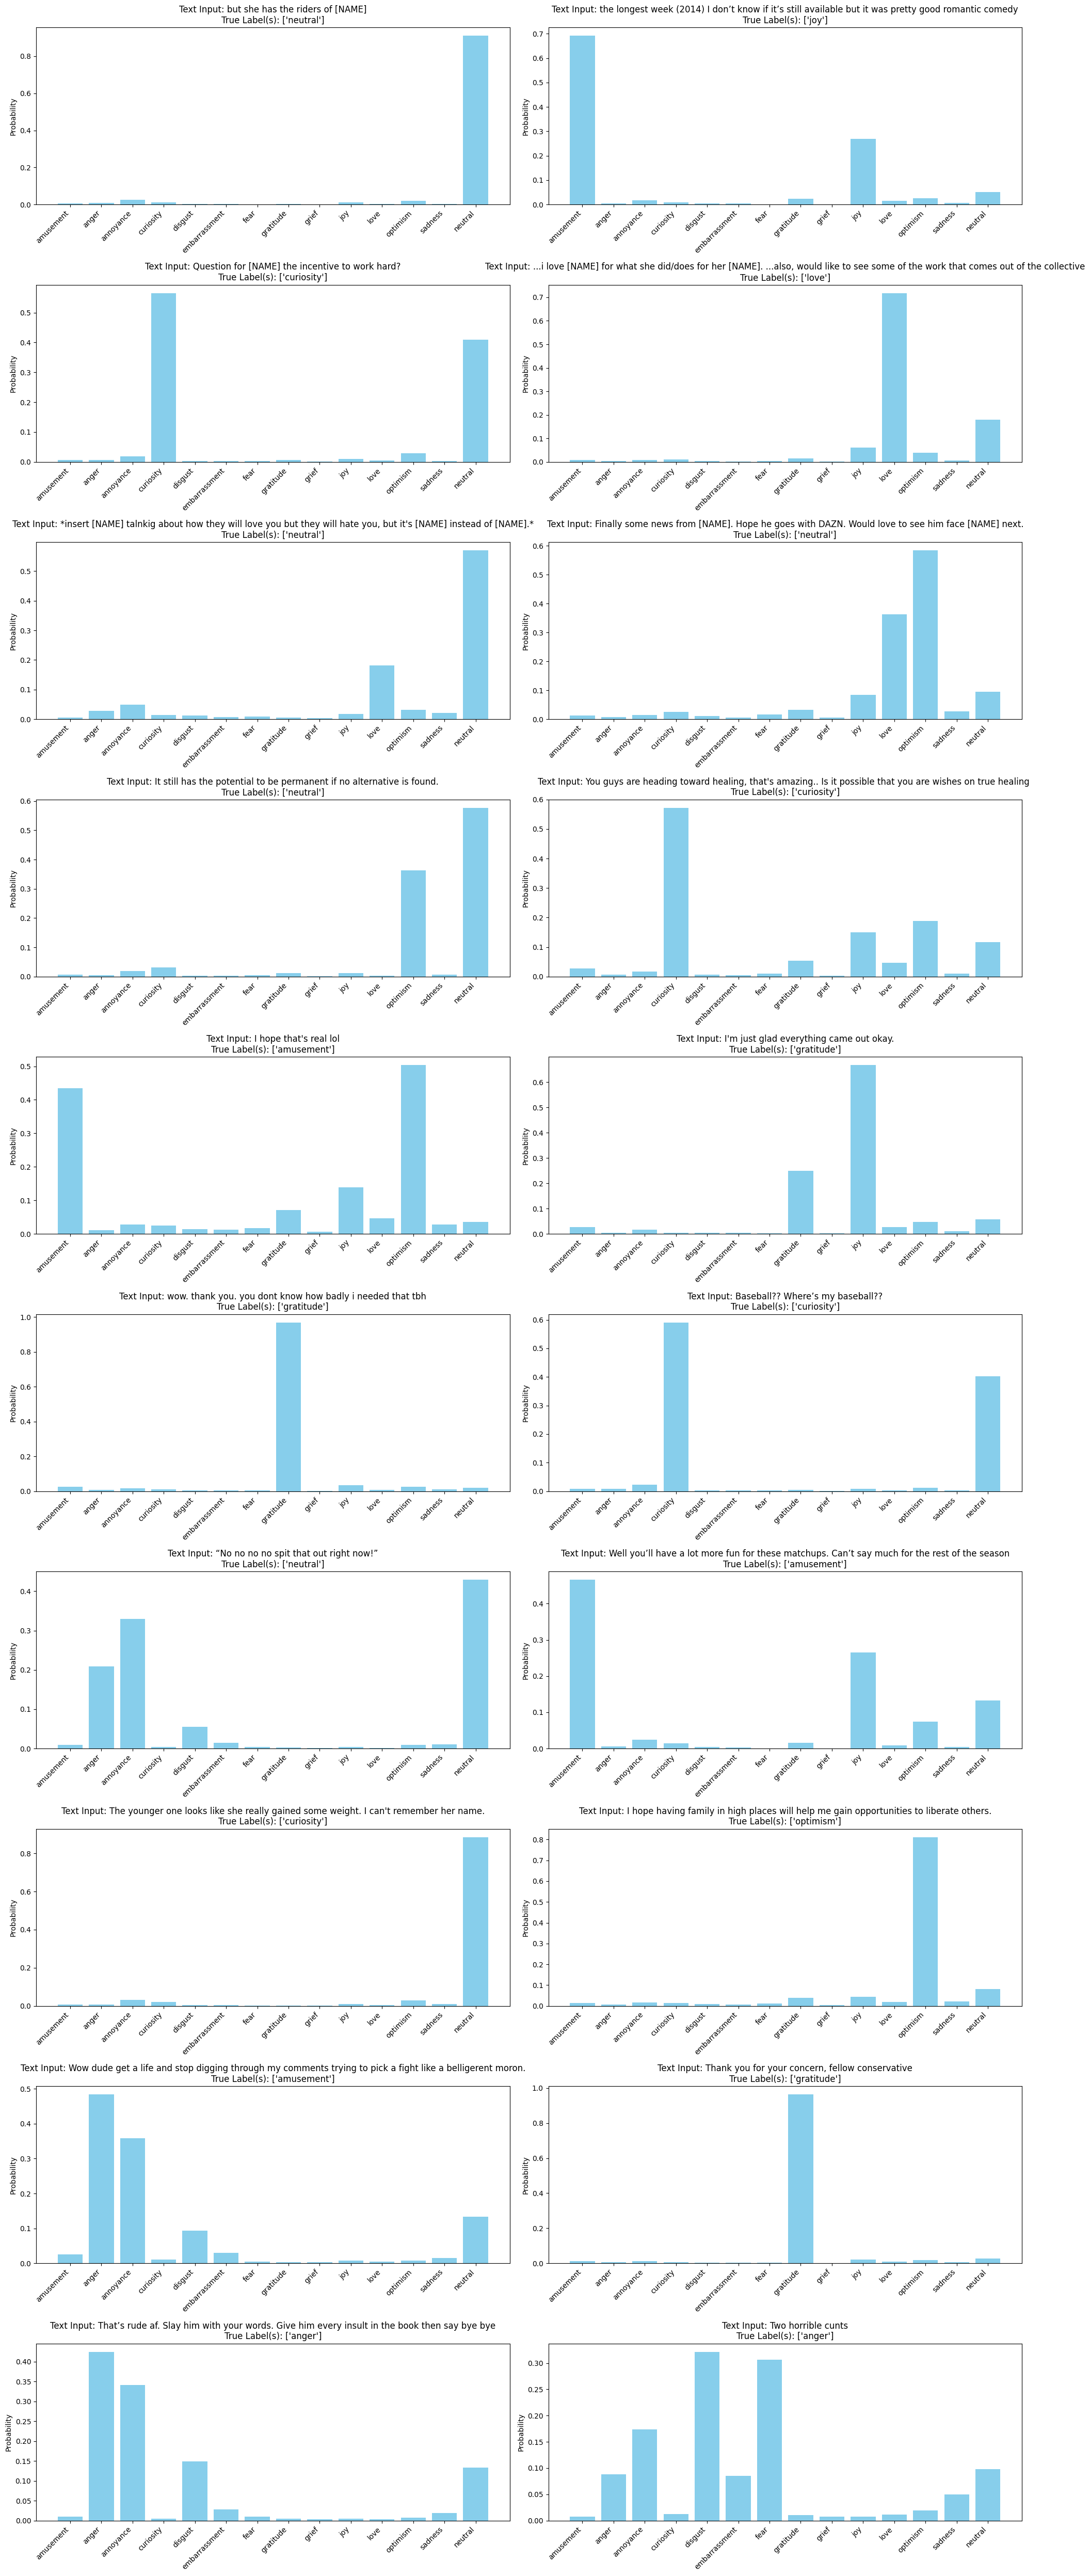

In [10]:
# evaluate test dataset on model (after training is completely finished)
print("\nEvaluating model on test dataset...")
test_results = trainer.predict(test_dataset=tokenized_dataset['test'])
print(f"Test evaluation completed.\nResults: {test_results.metrics}\n")

# apply sigmoid to the logits to get probabilities
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(test_results.predictions))
probs = probs.numpy()

# map probabilities to emotion classes
emotions = get_parameters()['emotions']
emotion_probabilities = map_probs_to_emotions(probs, emotions)

# Visualize the predictions for the first instances
# Extract the true labels from the test dataset
true_labels = tokenized_dataset['test']['labels']

# Convert the list of lists of label indices to lists of label names
true_labels_names = []
for label_row in true_labels:
    label_names = [emotions[idx] for idx, label in enumerate(label_row) if label == 1]
    true_labels_names.append(label_names)

# Truncate the lists to match the number of predictions you want to visualize
num_to_visualize = 20
visualize_emotion_probabilities(emotion_probabilities[:num_to_visualize],
                                test_texts[:num_to_visualize],
                                true_labels_names[:num_to_visualize])